In [1]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip install tensorflow==2.4.1
!pip install keras==2.4.3

Found existing installation: Keras 2.4.3
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: tensorflow 2.4.1
Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
  Using cached tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl (394.3 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [21]:
import numpy as np
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras import callbacks
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot
import os

logdir = os.path.join("callbacks")


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



# load dataset
dataset = pd.read_csv('CER_test.csv', header=0, index_col=0)
print(dataset.head())
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)




                     SYSLoad  holidays  Hour  Days  Month  Temperature  \
Timepoint                                                                
2009-07-14 00:00:00  464.058         0   0.0    14      7         11.8   
2009-07-14 00:30:00  400.316         0   0.5    14      7         11.8   
2009-07-14 01:00:00  353.643         0   1.0    14      7         11.8   
2009-07-14 01:30:00  320.181         0   1.5    14      7         11.6   
2009-07-14 02:00:00  293.990         0   2.0    14      7         11.4   

                     humiduity  Wind_speed  
Timepoint                                   
2009-07-14 00:00:00       93.0        14.4  
2009-07-14 00:30:00       91.0        14.4  
2009-07-14 01:00:00       89.0        18.0  
2009-07-14 01:30:00       91.0        18.0  
2009-07-14 02:00:00       93.0        10.8  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.175882        0.0   0.000000   0.433333   0.545455   0.673469   
2   0.126252        0.0 

In [9]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=1e-1, input_shape=(train_X.shape[1], train_X.shape[2])):
    model = Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(layers.LSTM(n_neurons, return_sequences=True, activation="relu"))
#        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

param_distribs= {
    "n_hidden": np.arange(1, 10).tolist(),
    "n_neurons": np.arange(30, 300).tolist(),
    "learning_rate": [1e-4, 1e-3, 1e-2, 1e-1],
}

checkpoint_cb = keras.callbacks.ModelCheckpoint('load_forecasting_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(train_X, train_y, epochs=150, validation_split=0.1, shuffle=True, batch_size=32,
                  callbacks=[checkpoint_cb, early_stopping_cb])


print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)



Epoch 1/150
572/572 [==============================] - 4s 4ms/step - loss: 0.0969 - mape: 1065.5621 - val_loss: 0.0266 - val_mape: 6.9894
Epoch 2/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0221 - mape: 1801.0727 - val_loss: 0.0303 - val_mape: 7.9819
Epoch 3/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0221 - mape: 2493.0941 - val_loss: 0.0281 - val_mape: 6.9895
Epoch 4/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0211 - mape: 2018.9241 - val_loss: 0.0249 - val_mape: 7.0875
Epoch 5/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0207 - mape: 1470.6056 - val_loss: 0.0245 - val_mape: 6.7535
Epoch 6/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0206 - mape: 26.7411 - val_loss: 0.0250 - val_mape: 6.3869
Epoch 7/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0199 - mape: 5454.6208 - val_loss: 0.0281 - val_mape: 7.6443
Epoch 8/150
572/572 [===============

572/572 [==============================] - 2s 4ms/step - loss: 0.0164 - mape: 83.5962 - val_loss: 0.0203 - val_mape: 5.4330
Epoch 61/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0166 - mape: 1107.6832 - val_loss: 0.0233 - val_mape: 6.1453
Epoch 62/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0165 - mape: 3017.2786 - val_loss: 0.0201 - val_mape: 5.4572
Epoch 63/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0162 - mape: 147.2194 - val_loss: 0.0200 - val_mape: 5.6049
Epoch 64/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0167 - mape: 536.4184 - val_loss: 0.0216 - val_mape: 5.7290
Epoch 65/150
159/159 [==============================] - 0s 1ms/step - loss: 0.0213 - mape: 9.4337
Epoch 1/150
572/572 [==============================] - 4s 4ms/step - loss: 0.0842 - mape: 29215.3912 - val_loss: 0.0278 - val_mape: 7.2027
Epoch 2/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0204 - m

572/572 [==============================] - 2s 4ms/step - loss: 0.0178 - mape: 457.4793 - val_loss: 0.0265 - val_mape: 6.8825
Epoch 35/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0188 - mape: 866.0862 - val_loss: 0.0220 - val_mape: 5.9445
Epoch 36/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0180 - mape: 89.2140 - val_loss: 0.0310 - val_mape: 9.0636
Epoch 37/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0183 - mape: 570.8544 - val_loss: 0.0230 - val_mape: 6.4911
Epoch 38/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0175 - mape: 1170.5392 - val_loss: 0.0218 - val_mape: 5.7614
Epoch 39/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0178 - mape: 314.3367 - val_loss: 0.0262 - val_mape: 7.3825
Epoch 40/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0179 - mape: 1416.3877 - val_loss: 0.0248 - val_mape: 6.3466
Epoch 41/150
159/159 [========================

572/572 [==============================] - 2s 4ms/step - loss: 0.0188 - mape: 7.1371 - val_loss: 0.0220 - val_mape: 5.8818
Epoch 53/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0182 - mape: 6.8005 - val_loss: 0.0203 - val_mape: 5.5194
Epoch 54/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0181 - mape: 6.7494 - val_loss: 0.0291 - val_mape: 7.8751
Epoch 55/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0182 - mape: 7.0113 - val_loss: 0.0203 - val_mape: 5.5646
Epoch 56/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0184 - mape: 6.8798 - val_loss: 0.0223 - val_mape: 6.0144
Epoch 57/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0177 - mape: 6.6704 - val_loss: 0.0220 - val_mape: 5.8315
Epoch 58/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0179 - mape: 6.9287 - val_loss: 0.0209 - val_mape: 5.5908
Epoch 59/150
572/572 [==============================] - 2s 4m

572/572 [==============================] - 3s 5ms/step - loss: 0.1304 - mape: 16216.8497 - val_loss: 0.1916 - val_mape: 57.2124
Epoch 6/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1321 - mape: 45395.7374 - val_loss: 0.1728 - val_mape: 60.1175
Epoch 7/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1325 - mape: 5764.8762 - val_loss: 0.1822 - val_mape: 58.4637
Epoch 8/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1334 - mape: 3830.6716 - val_loss: 0.1612 - val_mape: 63.4857
Epoch 9/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1316 - mape: 1371.8183 - val_loss: 0.1756 - val_mape: 59.5636
Epoch 10/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1316 - mape: 22194.9324 - val_loss: 0.1690 - val_mape: 60.9773
Epoch 11/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1313 - mape: 2021.7589 - val_loss: 0.1826 - val_mape: 58.3991
Epoch 12/150
572/572 [============

572/572 [==============================] - 3s 5ms/step - loss: 0.1541 - mape: 139.1474 - val_loss: 0.1579 - val_mape: 65.1691
Epoch 24/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1913 - mape: 84906.6797
Epoch 1/150
572/572 [==============================] - 8s 6ms/step - loss: 0.1593 - mape: 66713.5569 - val_loss: 0.1109 - val_mape: 251.1681
Epoch 2/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1544 - mape: 16383.8375 - val_loss: 0.1294 - val_mape: 298.7332
Epoch 3/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1556 - mape: 20916.3240 - val_loss: 0.1124 - val_mape: 261.0750
Epoch 4/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1521 - mape: 31703.5672 - val_loss: 0.1552 - val_mape: 333.9704
Epoch 5/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1560 - mape: 2764.4259 - val_loss: 0.1314 - val_mape: 301.8493
Epoch 6/150
572/572 [==============================] - 3s 6ms/step -

572/572 [==============================] - 3s 5ms/step - loss: 0.1530 - mape: 8884.4810 - val_loss: 0.1698 - val_mape: 60.7670
Epoch 4/150
572/572 [==============================] - 3s 6ms/step - loss: 0.1517 - mape: 37526.7279 - val_loss: 0.1815 - val_mape: 58.5699
Epoch 5/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1527 - mape: 9083.3802 - val_loss: 0.1884 - val_mape: 57.5988
Epoch 6/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1520 - mape: 9519.9486 - val_loss: 0.1616 - val_mape: 63.3195
Epoch 7/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1539 - mape: 1175.9257 - val_loss: 0.1940 - val_mape: 56.9497
Epoch 8/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1523 - mape: 5618.7376 - val_loss: 0.1908 - val_mape: 57.3098
Epoch 9/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1542 - mape: 5650.0493 - val_loss: 0.1649 - val_mape: 62.1453
Epoch 10/150
572/572 [================

572/572 [==============================] - 3s 5ms/step - loss: 0.1526 - mape: 849.3284 - val_loss: 0.1253 - val_mape: 291.9931
Epoch 18/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1524 - mape: 38515.9544 - val_loss: 0.1129 - val_mape: 263.4805
Epoch 19/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1535 - mape: 25414.8480 - val_loss: 0.1493 - val_mape: 326.5239
Epoch 20/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1555 - mape: 16280.3195 - val_loss: 0.1105 - val_mape: 242.4714
Epoch 21/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1524 - mape: 1158.4177 - val_loss: 0.1106 - val_mape: 246.0996
Epoch 22/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1551 - mape: 6152.6234 - val_loss: 0.1176 - val_mape: 277.1044
Epoch 23/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1565 - mape: 2089.5822 - val_loss: 0.1223 - val_mape: 286.7723
Epoch 24/150
572/572 [==

572/572 [==============================] - 2s 3ms/step - loss: 0.0241 - mape: 2843.7222 - val_loss: 0.0243 - val_mape: 6.3775
Epoch 5/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0227 - mape: 48.4022 - val_loss: 0.0251 - val_mape: 6.5047
Epoch 6/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0218 - mape: 653.4099 - val_loss: 0.0348 - val_mape: 11.1383
Epoch 7/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0221 - mape: 1369.4135 - val_loss: 0.0277 - val_mape: 7.0498
Epoch 8/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0221 - mape: 6922.6056 - val_loss: 0.0241 - val_mape: 6.2913
Epoch 9/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0213 - mape: 96.7615 - val_loss: 0.0275 - val_mape: 8.0739
Epoch 10/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0214 - mape: 2634.5042 - val_loss: 0.0238 - val_mape: 6.1887
Epoch 11/150
572/572 [===========================

572/572 [==============================] - 2s 3ms/step - loss: 0.0191 - mape: 8.0009 - val_loss: 0.0190 - val_mape: 5.4607
Epoch 44/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0191 - mape: 8.2548 - val_loss: 0.0192 - val_mape: 5.5556
Epoch 45/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0187 - mape: 7.5858 - val_loss: 0.0213 - val_mape: 6.0328
Epoch 46/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0189 - mape: 8.0006 - val_loss: 0.0205 - val_mape: 6.0705
Epoch 47/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0186 - mape: 7.5796 - val_loss: 0.0229 - val_mape: 6.0228
Epoch 48/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0195 - mape: 8.0613 - val_loss: 0.0217 - val_mape: 5.8635
Epoch 49/150
572/572 [==============================] - 2s 3ms/step - loss: 0.0185 - mape: 7.7353 - val_loss: 0.0353 - val_mape: 9.8850
Epoch 50/150
572/572 [==============================] - 2s 4m

572/572 [==============================] - 1s 1ms/step - loss: 0.0359 - mape: 65.1647 - val_loss: 0.0264 - val_mape: 7.3452
Epoch 7/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0302 - mape: 969.6148 - val_loss: 0.0374 - val_mape: 10.8304
Epoch 8/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0316 - mape: 7589.4027 - val_loss: 0.0368 - val_mape: 11.6890
Epoch 9/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0310 - mape: 1134.1519 - val_loss: 0.0331 - val_mape: 11.7877
Epoch 10/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0281 - mape: 3353.9508 - val_loss: 0.0275 - val_mape: 7.3561
Epoch 11/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0299 - mape: 2439.4719 - val_loss: 0.0289 - val_mape: 7.4937
Epoch 12/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0306 - mape: 78.4720 - val_loss: 0.0286 - val_mape: 8.3683
Epoch 13/150
572/572 [=======================

Epoch 10/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0309 - mape: 176.4407 - val_loss: 0.0277 - val_mape: 8.8233
Epoch 11/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0304 - mape: 504.8816 - val_loss: 0.0307 - val_mape: 11.1058
Epoch 12/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0302 - mape: 24.5726 - val_loss: 0.0389 - val_mape: 13.5788
Epoch 13/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0341 - mape: 1009.7934 - val_loss: 0.0277 - val_mape: 7.8954
Epoch 14/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0281 - mape: 897.4213 - val_loss: 0.0388 - val_mape: 11.4426
Epoch 15/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0305 - mape: 32.5426 - val_loss: 0.0271 - val_mape: 8.6683
Epoch 16/150
572/572 [==============================] - 1s 1ms/step - loss: 0.0272 - mape: 50.0914 - val_loss: 0.0274 - val_mape: 7.2134
Epoch 17/150
159/159 [===========

572/572 [==============================] - 1s 2ms/step - loss: 0.0230 - mape: 2964.5352 - val_loss: 0.0273 - val_mape: 8.4169
Epoch 6/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0222 - mape: 848.2117 - val_loss: 0.0271 - val_mape: 6.9442
Epoch 7/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0219 - mape: 85.1158 - val_loss: 0.0260 - val_mape: 6.8141
Epoch 8/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0222 - mape: 4853.0238 - val_loss: 0.0247 - val_mape: 7.0683
Epoch 9/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0216 - mape: 61.7989 - val_loss: 0.0239 - val_mape: 6.3170
Epoch 10/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0214 - mape: 1977.0953 - val_loss: 0.0375 - val_mape: 10.5296
Epoch 11/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0215 - mape: 2908.1426 - val_loss: 0.0285 - val_mape: 7.9451
Epoch 12/150
572/572 [==========================

572/572 [==============================] - 1s 2ms/step - loss: 0.0211 - mape: 3021.9809 - val_loss: 0.0259 - val_mape: 6.8199
Epoch 16/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0209 - mape: 295.4668 - val_loss: 0.0251 - val_mape: 6.4285
Epoch 17/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0210 - mape: 1411.7386 - val_loss: 0.0320 - val_mape: 8.2355
Epoch 18/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0210 - mape: 381.8309 - val_loss: 0.0250 - val_mape: 6.5534
Epoch 19/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0208 - mape: 674.8995 - val_loss: 0.0233 - val_mape: 6.3416
Epoch 20/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0204 - mape: 508.9140 - val_loss: 0.0251 - val_mape: 6.4382
Epoch 21/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0201 - mape: 646.9352 - val_loss: 0.0235 - val_mape: 6.2154
Epoch 22/150
572/572 [=======================

572/572 [==============================] - 1s 2ms/step - loss: 0.0213 - mape: 8.6035 - val_loss: 0.0244 - val_mape: 7.0825
Epoch 26/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0214 - mape: 8.5591 - val_loss: 0.0236 - val_mape: 6.2184
Epoch 27/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0215 - mape: 8.6062 - val_loss: 0.0311 - val_mape: 9.9848
Epoch 28/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0208 - mape: 8.4590 - val_loss: 0.0229 - val_mape: 6.1367
Epoch 29/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0210 - mape: 8.3095 - val_loss: 0.0244 - val_mape: 6.8066
Epoch 30/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0210 - mape: 8.1903 - val_loss: 0.0226 - val_mape: 6.1088
Epoch 31/150
572/572 [==============================] - 1s 2ms/step - loss: 0.0212 - mape: 8.1958 - val_loss: 0.0256 - val_mape: 7.1360
Epoch 32/150
572/572 [==============================] - 1s 2m

572/572 [==============================] - 2s 4ms/step - loss: 0.0187 - mape: 1775.9800 - val_loss: 0.0222 - val_mape: 5.8896
Epoch 27/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0189 - mape: 1096.8359 - val_loss: 0.0215 - val_mape: 5.7859
Epoch 28/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0184 - mape: 414.5384 - val_loss: 0.0218 - val_mape: 5.7560
Epoch 29/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0188 - mape: 262.7950 - val_loss: 0.0233 - val_mape: 6.7671
Epoch 30/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0183 - mape: 760.7312 - val_loss: 0.0227 - val_mape: 6.2082
Epoch 31/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0184 - mape: 767.2860 - val_loss: 0.0212 - val_mape: 5.6703
Epoch 32/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0185 - mape: 1987.5895 - val_loss: 0.0227 - val_mape: 6.1697
Epoch 33/150
572/572 [======================

572/572 [==============================] - 2s 4ms/step - loss: 0.0201 - mape: 308.8472 - val_loss: 0.0247 - val_mape: 6.3248
Epoch 8/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0204 - mape: 828.7226 - val_loss: 0.0253 - val_mape: 6.5203
Epoch 9/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0198 - mape: 412.2066 - val_loss: 0.0260 - val_mape: 7.4841
Epoch 10/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0203 - mape: 707.7197 - val_loss: 0.0255 - val_mape: 6.6226
Epoch 11/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0202 - mape: 767.8493 - val_loss: 0.0251 - val_mape: 6.4792
Epoch 12/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0200 - mape: 371.4163 - val_loss: 0.0251 - val_mape: 6.5209
Epoch 13/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0199 - mape: 478.3708 - val_loss: 0.0249 - val_mape: 6.9916
Epoch 14/150
572/572 [===========================

572/572 [==============================] - 2s 4ms/step - loss: 0.0184 - mape: 7.0234 - val_loss: 0.0222 - val_mape: 5.9832
Epoch 51/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0189 - mape: 7.2171 - val_loss: 0.0228 - val_mape: 6.4535
Epoch 52/150
159/159 [==============================] - 0s 1ms/step - loss: 0.0144 - mape: 4854.5859
Epoch 1/150
572/572 [==============================] - 5s 5ms/step - loss: 0.1212 - mape: 525.0371 - val_loss: 0.0191 - val_mape: 13.5397
Epoch 2/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0234 - mape: 321.6155 - val_loss: 0.0240 - val_mape: 20.0065
Epoch 3/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0233 - mape: 1545.8506 - val_loss: 0.0158 - val_mape: 10.5971
Epoch 4/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0222 - mape: 117.6110 - val_loss: 0.0155 - val_mape: 10.3481
Epoch 5/150
572/572 [==============================] - 2s 4ms/step - loss: 0.0221 - map

Epoch 10/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1500 - mape: 55415.9639 - val_loss: 0.1677 - val_mape: 61.3183
Epoch 11/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1492 - mape: 41229.0118 - val_loss: 0.1636 - val_mape: 62.5632
Epoch 12/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1503 - mape: 750.3322 - val_loss: 0.1536 - val_mape: 69.9673
Epoch 13/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1531 - mape: 39078.8420 - val_loss: 0.1732 - val_mape: 60.0404
Epoch 14/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1507 - mape: 12853.9862 - val_loss: 0.1926 - val_mape: 57.1076
Epoch 15/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1523 - mape: 7827.7918 - val_loss: 0.1695 - val_mape: 60.8523
Epoch 16/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1469 - mape: 4545.5303 - val_loss: 0.1644 - val_mape: 62.3087
Epoch 17/150
572/

Epoch 12/150
572/572 [==============================] - 3s 4ms/step - loss: 0.1541 - mape: 141.6845 - val_loss: 0.1559 - val_mape: 66.5993
Epoch 13/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1567 - mape: 146.1006 - val_loss: 0.1594 - val_mape: 64.3517
Epoch 14/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1557 - mape: 145.5875 - val_loss: 0.1571 - val_mape: 65.7276
Epoch 15/150
572/572 [==============================] - 2s 4ms/step - loss: 0.1540 - mape: 142.4295 - val_loss: 0.1565 - val_mape: 66.1468
Epoch 16/150
159/159 [==============================] - 0s 1ms/step - loss: 0.1736 - mape: 81232.3359
Epoch 1/150
572/572 [==============================] - 7s 6ms/step - loss: 0.1584 - mape: 24766.3519 - val_loss: 0.1464 - val_mape: 322.7893
Epoch 2/150
572/572 [==============================] - 3s 5ms/step - loss: 0.1547 - mape: 1921.5785 - val_loss: 0.1119 - val_mape: 225.5487
Epoch 3/150
572/572 [==============================] - 3s 5ms

Epoch 19/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1497 - mape: 7855.2389 - val_loss: 0.1840 - val_mape: 58.1892
Epoch 20/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1493 - mape: 9841.5183 - val_loss: 0.1709 - val_mape: 60.5213
Epoch 21/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1501 - mape: 5534.5008 - val_loss: 0.1679 - val_mape: 61.2511
Epoch 22/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1511 - mape: 6969.5990 - val_loss: 0.1621 - val_mape: 63.1185
Epoch 23/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1502 - mape: 8822.8554 - val_loss: 0.1735 - val_mape: 59.9661
Epoch 24/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1485 - mape: 8474.7542 - val_loss: 0.1605 - val_mape: 63.7896
Epoch 25/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1477 - mape: 220.6798
Epoch 1/150
572/572 [==============================] - 8s 8m

Epoch 4/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1560 - mape: 145.2589 - val_loss: 0.1772 - val_mape: 59.2784
Epoch 5/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1550 - mape: 142.6032 - val_loss: 0.1659 - val_mape: 61.8191
Epoch 6/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1557 - mape: 147.0535 - val_loss: 0.1648 - val_mape: 62.1815
Epoch 7/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1542 - mape: 139.2082 - val_loss: 0.1614 - val_mape: 63.3964
Epoch 8/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1558 - mape: 138.1428 - val_loss: 0.1596 - val_mape: 64.2084
Epoch 9/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1554 - mape: 144.5248 - val_loss: 0.1598 - val_mape: 64.1475
Epoch 10/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1527 - mape: 141.2483 - val_loss: 0.1607 - val_mape: 63.7158
Epoch 11/150
572/572 [===========

Epoch 33/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1528 - mape: 13196.2427 - val_loss: 0.1467 - val_mape: 323.1629
Epoch 34/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1536 - mape: 10993.0828 - val_loss: 0.1948 - val_mape: 380.7075
Epoch 35/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1545 - mape: 4968.4743 - val_loss: 0.1131 - val_mape: 264.3220
Epoch 36/150
572/572 [==============================] - 4s 8ms/step - loss: 0.1567 - mape: 2434.7309 - val_loss: 0.1212 - val_mape: 284.6373
Epoch 37/150
572/572 [==============================] - 4s 7ms/step - loss: 0.1542 - mape: 8456.9723 - val_loss: 0.1405 - val_mape: 315.0224
Epoch 38/150
159/159 [==============================] - 0s 2ms/step - loss: 0.1483 - mape: 147.3040
Epoch 1/150
572/572 [==============================] - 13s 17ms/step - loss: 0.1084 - mape: 846.9036 - val_loss: 0.0258 - val_mape: 6.7549
Epoch 2/150
572/572 [==============================] -

572/572 [==============================] - 16s 27ms/step - loss: 0.0209 - mape: 30.5133 - val_loss: 0.0251 - val_mape: 6.5033
Epoch 8/150
572/572 [==============================] - 16s 28ms/step - loss: 0.0212 - mape: 3477.6848 - val_loss: 0.0265 - val_mape: 8.4143
Epoch 9/150
572/572 [==============================] - 16s 28ms/step - loss: 0.0208 - mape: 1534.2171 - val_loss: 0.0241 - val_mape: 6.3472
Epoch 10/150
572/572 [==============================] - 15s 27ms/step - loss: 0.0201 - mape: 2020.9786 - val_loss: 0.0242 - val_mape: 6.3590
Epoch 11/150
572/572 [==============================] - 16s 28ms/step - loss: 0.0197 - mape: 655.8460 - val_loss: 0.0274 - val_mape: 6.8512
Epoch 12/150
572/572 [==============================] - 16s 27ms/step - loss: 0.0206 - mape: 38.6437 - val_loss: 0.0256 - val_mape: 6.7413
Epoch 13/150
572/572 [==============================] - 16s 28ms/step - loss: 0.0201 - mape: 1492.5273 - val_loss: 0.0290 - val_mape: 7.3500
Epoch 14/150
572/572 [===========

572/572 [==============================] - 16s 27ms/step - loss: 0.0169 - mape: 1260.4992 - val_loss: 0.0225 - val_mape: 6.1101
Epoch 66/150
572/572 [==============================] - 16s 27ms/step - loss: 0.0168 - mape: 1369.0454 - val_loss: 0.0209 - val_mape: 5.6936
Epoch 67/150
572/572 [==============================] - 16s 27ms/step - loss: 0.0166 - mape: 1688.0505 - val_loss: 0.0187 - val_mape: 5.4571
Epoch 68/150
572/572 [==============================] - 16s 28ms/step - loss: 0.0169 - mape: 507.6598 - val_loss: 0.0219 - val_mape: 6.0386
Epoch 69/150
572/572 [==============================] - 16s 27ms/step - loss: 0.0166 - mape: 746.7708 - val_loss: 0.0226 - val_mape: 6.5191
Epoch 70/150
572/572 [==============================] - 17s 29ms/step - loss: 0.0170 - mape: 390.7577 - val_loss: 0.0208 - val_mape: 5.7410
Epoch 71/150
572/572 [==============================] - 16s 27ms/step - loss: 0.0170 - mape: 347.9439 - val_loss: 0.0252 - val_mape: 7.0930
Epoch 72/150
572/572 [========

572/572 [==============================] - 18s 32ms/step - loss: 0.0187 - mape: 7.4508 - val_loss: 0.0242 - val_mape: 6.1431
Epoch 37/150
572/572 [==============================] - 19s 33ms/step - loss: 0.0183 - mape: 7.0283 - val_loss: 0.0204 - val_mape: 5.5267
Epoch 38/150
572/572 [==============================] - 19s 33ms/step - loss: 0.0185 - mape: 7.0997 - val_loss: 0.0197 - val_mape: 5.4178
Epoch 39/150
572/572 [==============================] - 18s 32ms/step - loss: 0.0187 - mape: 7.3802 - val_loss: 0.0209 - val_mape: 6.0832
Epoch 40/150
572/572 [==============================] - 18s 31ms/step - loss: 0.0186 - mape: 7.0114 - val_loss: 0.0254 - val_mape: 6.9882
Epoch 41/150
572/572 [==============================] - 17s 30ms/step - loss: 0.0185 - mape: 7.0915 - val_loss: 0.0187 - val_mape: 5.5364
Epoch 42/150
572/572 [==============================] - 18s 32ms/step - loss: 0.0183 - mape: 7.0121 - val_loss: 0.0214 - val_mape: 6.2088
Epoch 43/150
572/572 [=========================

715/715 [==============================] - 6s 9ms/step - loss: 0.0197 - mape: 345.0638 - val_loss: 0.0248 - val_mape: 7.3264
Epoch 9/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0197 - mape: 406.4680 - val_loss: 0.0250 - val_mape: 6.7649
Epoch 10/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0200 - mape: 121.2112 - val_loss: 0.0244 - val_mape: 6.6787
Epoch 11/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0197 - mape: 1760.4556 - val_loss: 0.0233 - val_mape: 6.7173
Epoch 12/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0190 - mape: 135.2405 - val_loss: 0.0286 - val_mape: 7.6750
Epoch 13/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0198 - mape: 2323.0385 - val_loss: 0.0252 - val_mape: 6.7288
Epoch 14/150
715/715 [==============================] - 6s 8ms/step - loss: 0.0192 - mape: 1069.6359 - val_loss: 0.0224 - val_mape: 6.2263
Epoch 15/150
715/715 [=======================

(25391, 1, 8) (25391,) (336, 1, 8) (336,)
Epoch 1/150
794/794 - 3s - loss: 0.0424 - mape: 1355.3807 - val_loss: 0.0373 - val_mape: 12.1287
Epoch 2/150
794/794 - 1s - loss: 0.0281 - mape: 1056.2095 - val_loss: 0.0322 - val_mape: 9.6631
Epoch 3/150
794/794 - 1s - loss: 0.0250 - mape: 1401.5448 - val_loss: 0.0246 - val_mape: 6.5637
Epoch 4/150
794/794 - 1s - loss: 0.0237 - mape: 1673.6685 - val_loss: 0.0230 - val_mape: 6.2975
Epoch 5/150
794/794 - 1s - loss: 0.0229 - mape: 1508.2195 - val_loss: 0.0269 - val_mape: 8.0690
Epoch 6/150
794/794 - 1s - loss: 0.0229 - mape: 1472.0399 - val_loss: 0.0208 - val_mape: 5.6264
Epoch 7/150
794/794 - 1s - loss: 0.0226 - mape: 1452.3662 - val_loss: 0.0215 - val_mape: 5.6880
Epoch 8/150
794/794 - 1s - loss: 0.0224 - mape: 1248.9021 - val_loss: 0.0211 - val_mape: 5.7607
Epoch 9/150
794/794 - 1s - loss: 0.0222 - mape: 1266.7615 - val_loss: 0.0203 - val_mape: 5.2759
Epoch 10/150
794/794 - 1s - loss: 0.0222 - mape: 1229.7527 - val_loss: 0.0201 - val_mape: 5.3

Epoch 86/150
794/794 - 1s - loss: 0.0204 - mape: 908.8763 - val_loss: 0.0219 - val_mape: 5.9762
Epoch 87/150
794/794 - 1s - loss: 0.0204 - mape: 865.1802 - val_loss: 0.0219 - val_mape: 5.9659
Epoch 88/150
794/794 - 1s - loss: 0.0204 - mape: 933.6549 - val_loss: 0.0234 - val_mape: 6.5019
Epoch 89/150
794/794 - 1s - loss: 0.0204 - mape: 870.7410 - val_loss: 0.0235 - val_mape: 6.4342
Epoch 90/150
794/794 - 1s - loss: 0.0203 - mape: 862.8062 - val_loss: 0.0226 - val_mape: 6.1545
Epoch 91/150
794/794 - 1s - loss: 0.0204 - mape: 957.6093 - val_loss: 0.0226 - val_mape: 6.1869
Epoch 92/150
794/794 - 1s - loss: 0.0204 - mape: 901.2778 - val_loss: 0.0229 - val_mape: 6.2853
Epoch 93/150
794/794 - 1s - loss: 0.0204 - mape: 842.6257 - val_loss: 0.0232 - val_mape: 6.4047
Epoch 94/150
794/794 - 1s - loss: 0.0203 - mape: 886.3461 - val_loss: 0.0237 - val_mape: 6.5752
Epoch 95/150
794/794 - 1s - loss: 0.0204 - mape: 857.7939 - val_loss: 0.0230 - val_mape: 6.2899
Epoch 96/150
794/794 - 1s - loss: 0.0203

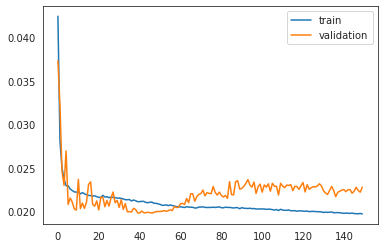

Test RMSE: 40.021
Test MAE: 29.261
Test MAPE: 0.039


In [25]:
'''
{['n_neurons': 183, 'n_hidden': 1, 'learning_rate': 0.001, 'batch_size': 56, 'mae':30.174194', mape':0.039118115]}
 ['n_neurons': 166, 'n_hidden': 1, 'learning_rate': 0.001, 'batch_size': 53]
 ['n_neurons': 70, 'n_hidden': 1, 'learning_rate': 0.001, 'batch_size': 70]
'''
from math import sqrt

# split into train and test sets
values = reframed.values
n_train_hours = 536 * 48 - 7 * 48 - 1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(183, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dropout(0.5))
#model.add(LSTM(201, return_sequences=False, activation="relu"))
#model.add(layers.Dropout(0.2))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mape'], optimizer=optimizer)
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

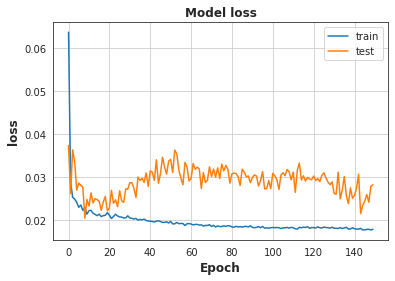

In [19]:
sns.set_style('white')
font1 = {'weight':'bold',
        'size':12,}
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Model loss', font1)
pyplot.xlabel('Epoch', font1)
pyplot.ylabel('loss', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('model loss of LSTM for aggregation households')
pyplot.show()

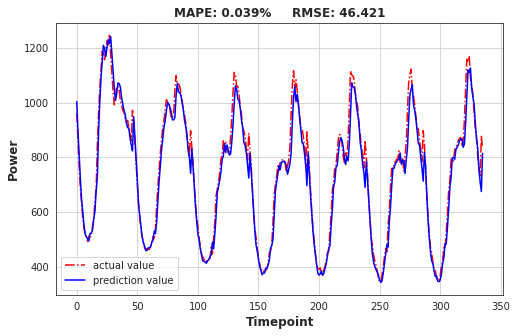

In [11]:

import seaborn as sns
pyplot.figure(figsize=(8, 5))
pyplot.plot(range(len(inv_y)), inv_y, ls='-.', c='red', label='actual value')
pyplot.plot(range(len(inv_yhat)), inv_yhat, ls='-', c='blue', label='prediction value')
pyplot.title('MAPE: %.3f%%' % mape + '     ' + 'RMSE: %.3f' % rmse, font1)
pyplot.xlabel('Timepoint', font1)
pyplot.ylabel('Power', font1)
pyplot.grid(True)
pyplot.legend()
pyplot.savefig('LSTM for aggregation households')
pyplot.show()